<center> <h1> PPOL 567 Massive Data Fundamentals </h1> <br>
<h2> Final Project : Team 6 </h2> <br>
<h2> Exploratory Data Analysis </h2> </center>

For the purpose of the project we decided to use the r/worldnews subreddit that is a news-based subreddit where users post news articles for further discussion. The news articles deal with all issues except domestic US news. 

### Executive Summary

<b> Business Goal -1 : </b>

Analyze the user activity in the r/worldnews subreddit. What proportion of users participate in posting submissions and comments? Who are the users with the most controversial comments? Does controversiality also inform whether a user is likely to have gilded/distinguished comments?   

<b> Technical proposal: </b> Different aggregate tables will be created to answer the questions above. The number of distinct users posting or commenting would be compared against the total number of subscribers in the subreddit(obtained from an external source). Users with highest number of controversial comments will be listed and their total gilded and distinguished comments will be assessed. 

<b> Business Goal - 2 : </b>

What are the general trends in submissions and comments in the world news subreddit ? How do characteristic features of  the subreddit vary across time and compare with the general trend ? 

<b>Technical Proposal : </b> In order to perform time series analysis, the timestamp of the submission’s creation will be used. Data manipulations to find counts, averages, medians and other such arithmetic measures of different variables in the dataset will be performed. These calculations will then be visualized over time to identify different trends in the data, check if they are consistent or not, and if possible, identify seasonality in the time series visualizations. 

<b> Business Goal - 3 :</b>

What are the most popular new stories in the subreddit? What are the most shared news sites? Are there any live threads? If so, what are they pertaining to? 

<b> Technical proposal :</b> The most popular news stories can be derived from the score variable. The most shared news sites can be captured by aggregating on the domain column and assessing for the number of posts, comments, the average scores to name a few. It can also be determined if the news sites have any articles that are among the top popular ones. Live threads can be obtained using regex on the title column by applying an appropriate search term.  

<b>Business Goal - 4 : </b>

What are the most repetitive words in the comments under the top 5 news stories in the subreddit ?  

<b> Technical Proposal : </b> By filtering the “score” column from the dataset, the most popular subreddits can be found. Then word clouds can be created to explore the most frequent words in each of the top five subreddits. These visualizations give a take-away of the popular topics in the subreddit.

<b> Business Goal - 5 : </b>

Does world news subreddit capture all events in the Russia-Ukraine conflict? 

<b> Technical Proposal: </b> In order to compare posts regarding the Russia-Ukraine conflict, the ACLED (Armed Conflict Location and Event Data Project) data was used. ACLED collects real-time data on locations, dates, actors, fatalities and types of all reported political violence and protest events around the world, from various international and regional news sources. The ACLED data for Ukraine and Russia were aggregated to obtain daily counts of sub-event types in the following categories: 
    
- Armed Clashes
- Shelling/Artillery/Missile Attacks
- Remote Explosives/Landmines/IED
- Disrupted Weapons Use

Based on the definitions of the aforementioned sub-events from the ACLED codebook, appropriate words were used to find daily counts of event type from posts’s title using regex. Then, both the datasets are merged on the event date, and their counts are compared using a heatmap. 

<b> Business Goal - 6 : </b> 

What are the main topics in the submissions of the sub-reddit ? 

<b> Technical Proposal: </b> In order to identify the major topics under submissions related to the Russia - Ukraine crisis, topic modeling with LDA will be performed. Particularly, the LDA method for topic modeling will be used as its results are based on conditional probability estimates. Titles will be pre-processed to remove stop-words, punctuations, and non-alpha characters (this ensures that titles in languages other than English are removed from analysis). The ideal minimum document frequency for LDA will be found with TF-IDF( Term Frequency - Inverse Document Frequency). 

<b> Business Goal - 7 : </b> 

What are the key elements in the submissions and what categories can be they classified to? 

<b> Technical Proposal: </b> Named Entity recognition will be performed using the spacy package in Python. Apart from the predetermined ‘ents’ properties in the package, additional relevant labels will be created based on results from word clouds.The possibility of creating relevant labels for high frequency words in languages other than English in the dataset will be explored too.  Together, they shall be used to identify standard categories in the text data such as person’s name, geographic locations, organizations, monetary values etc. 

<b> Business Goal - 8 : </b>

What is the sentiment of comments under live thread posts? From previous analysis it was determined that the live threads were pertaining to Russia’s war against Ukraine. Given such a high stakes topic, do we expect the sentiment to be heavily one-sided or it is possible that there might  be highly mixed views? 

<b> Technical Proposal: </b> For conducting sentiment analysis, we propose to use a lexicon based approach using easily available lexicons like VaderSentiment and TextBlob. After preprocessing our texts and generating the labels using lexicons, we plan to either compare it against pre-trained models available through huggingface and also against a small subset of hand labeled sentiments. 

<b> Business Goal - 9 : </b>

Is it possible to scale our NLP models using supervised learning? How well would they perform and would the traditional evaluation metrics in supervised learning be useful in designing high performing models? 

<b> Technical Proposal: </b> After creating the sentiment analysis and topic models above, it is possible to train supervised models such as support vector machines, logistic regression etc. using the sentiment or topic labels as the target variable. A portion of the data can be used in topic modeling and sentiment analysis to obtain the required labels and the remaining data can be labeled by training supervised learning models.   

<b> Business Goal - 10 : </b>

Could individual user Karma scores be predicted by the variables in our dataset?  

<b> Technical Proposal: </b> Karma scores can often influence any user’s actions on a particular subreddit. After obtaining the set of users who post and comment, their Karma scores can be procured using the Reddit API. The Karma scores would then become our target variable and we can construct a number of predictors from the dataset such as number of submissions or comments posted, number of gilded comments etc. 

### Exploratory Data Analysis

In [85]:
### Importing required libraries 
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import isnan, when, count, col, lit
import pandas as pd
spark = SparkSession.builder.appName("reddit-bigdata-project").getOrCreate()

from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import date_format

#For visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### For word clouds 
from pyspark.sql.functions import udf, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import StringType, ArrayType, IntegerType

23/03/25 03:02:27 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
23/03/25 03:02:33 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [5]:
### Installing wordcloud
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [58]:
from wordcloud import WordCloud

In [86]:
spark

In [88]:
### Reading in the data from S3 bucket 
submissions = spark.read.parquet("s3a://ppol567-llj40-bucket-3/worldnews_new/submissions/")
comments = spark.read.parquet("s3a://ppol567-llj40-bucket-3/worldnews_new/comments/")

### Specifications of the Dataset 

In [7]:
### Assessing the basic details of the datasets
### Counting the number of rows 
print("The number of rows in submissions dataset is : ", submissions.count())
print("The number of rows in comments dataset is    : ", comments.count())
print("*********************************************************")
### Displaying the schema 
print("Displaying the schema of the submissions dataset : ")
submissions.printSchema()
print("Displaying the schema of the comments dataset : ")
comments.printSchema()
print("*********************************************************")
### Displaying the number of partitions 
print("Number of partitions in submission dataset : ", submissions.rdd.getNumPartitions())
print("Number of partitions in comments dataset   : ", comments.rdd.getNumPartitions())
print("*********************************************************")
### Displaying the first few rows 
print("Printing the first 10 rows of submissions data : ")
submissions.show(10)
print("Printing the first 10 rows of comments data : ")
comments.show(10)
print("*********************************************************")

The number of rows in submissions dataset is :  170144


The number of rows in comments dataset is    :  18548934
*********************************************************
Displaying the schema of the submissions dataset : 
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- quarantine: boolean (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- ur

+-------------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+---------+------------+
|             author|author_flair_css_class|author_flair_text|                body|controversiality|created_utc|distinguished|edited|gilded|     id|  link_id| parent_id|retrieved_on|score|stickied|subreddit|subreddit_id|
+-------------------+----------------------+-----------------+--------------------+----------------+-----------+-------------+------+------+-------+---------+----------+------------+-----+--------+---------+------------+
|          [deleted]|                  null|             null|           [deleted]|               0| 1645675541|         null|  null|     0|hy728gt|t3_t0082j|t1_hy6wgtf|  1655922006|   23|   false|worldnews|    t5_2qh13|
|          mimesocks|                  null|             null|Humans are not go...|               0| 1645675541|    

In [89]:
### Dropping columns subreddit and subreddit_id from both tables as this data contains the submissions and comments of only one subreddit 
cols_to_drop = ("subreddit", "subreddit_id")
submissions = submissions.drop(*cols_to_drop)
comments = comments.drop(*cols_to_drop)
### Checking if columns have been dropped 
submissions.printSchema()
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- quarantine: boolean (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = t

### Data Quality Checks 

#### Missing values

In [9]:
### Assessing missing values for particular columns in the submissions dataset 
s_d = submissions.dtypes ### Getting the datatypes of the columns 

### Combining columns of the same datatype in a list 
str_cols = [c[0] for c in s_d if c[1] == "string"]
num_cols = [c[0] for c in s_d if (c[1] == "bigint") or (c[1] == "double")]
bool_cols = [c[0] for c in s_d if c[1] == "boolean"]

### Checking for missing values in the columns 
print("Missing values in numerical columns : ")
submissions.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()
print("Missing values in string columns : ")
submissions.select([count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) for c in str_cols]).show()
print("Missing values in boolean columns : ")
submissions.select([count(when(col(c).isNull(), c)).alias(c) for c in bool_cols]).show()

Missing values in numerical columns : 


+-----------+------+------------+------------+-----+
|created_utc|edited|num_comments|retrieved_on|score|
+-----------+------+------------+------------+-----+
|          0|     0|           0|           0|    0|
+-----------+------+------------+------------+-----+

Missing values in string columns : 


+------+----------------------+-----------------+-------------+------+---+--------+-----+-----+
|author|author_flair_css_class|author_flair_text|distinguished|domain| id|selftext|title|  url|
+------+----------------------+-----------------+-------------+------+---+--------+-----+-----+
|     0|                170098|           169771|       170074| 18239|  0|  122946|    0|18239|
+------+----------------------+-----------------+-------------+------+---+--------+-----+-----+

Missing values in boolean columns : 


+-------+------+-------+----------+--------+
|is_self|locked|over_18|quarantine|stickied|
+-------+------+-------+----------+--------+
|      0|     0|      0|         0|       0|
+-------+------+-------+----------+--------+



In [10]:
### Assessing missing values for particular columns in the comments dataset following the same steps as above 
c_d = comments.dtypes
str_cols = [c[0] for c in c_d if c[1] == "string"]
num_cols = [c[0] for c in c_d if (c[1] == "bigint") or (c[1] == "double")]
bool_cols = [c[0] for c in c_d if c[1] == "boolean"]

### Checking missing values in columns 
print("Missing values in numerical columns : ")
comments.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()
print("Missing values in string columns : ")
comments.select([count(when(col(c).isNull() | (col(c) == ""), c)).alias(c) for c in str_cols]).show()
print("Missing values in boolean columns : ")
comments.select([count(when(col(c).isNull(), c)).alias(c) for c in bool_cols]).show()

Missing values in numerical columns : 


+----------------+-----------+------+------+------------+-----+
|controversiality|created_utc|edited|gilded|retrieved_on|score|
+----------------+-----------+------+------+------------+-----+
|               0|          0|     0|     0|           0|    0|
+----------------+-----------+------+------+------------+-----+

Missing values in string columns : 


+------+----------------------+-----------------+----+-------------+---+-------+---------+
|author|author_flair_css_class|author_flair_text|body|distinguished| id|link_id|parent_id|
+------+----------------------+-----------------+----+-------------+---+-------+---------+
|     0|              18548893|         18483213| 116|     18506326|  0|      0|        0|
+------+----------------------+-----------------+----+-------------+---+-------+---------+

Missing values in boolean columns : 


+--------+
|stickied|
+--------+
|       0|
+--------+



#### Duplicate values and Anomalies

In [90]:
### Assessing potential duplicates in our dataset. Looking at the values of title 
submissions.groupby("title").count().alias('count').orderBy(col("count").desc()).show(10)

### Removing rows that contain deleted by user as title 
df_sub = submissions.filter(col("title") != "[deleted by user]").cache()

### Looking at rows that have count of more than one in title 
df_sub.groupby("title").count().alias('count').filter('count > 1').orderBy(col("count").desc()).show(10, truncate = False)

### Looking at the domains for the first title 
df_sub.filter(col("title") == "New video by KAILASA's SPH Nithyananda on YouTube").select("domain", "url", "score").show(10, truncate = False)

### This indicates that the other titles might also be duplicates 
### Thus we can remove those rows that are duplicates in the title columns 
df_sub = df_sub.dropDuplicates(["title"]).cache()
### Counting the number of rows 
df_sub.count()

### Similar analysis can be performed on the comments dataset with the body column  
comments.groupby("body").count().alias("count").orderBy(col("count").desc()).show(10, truncate = False)

### The above output shows that there are a set of rows where the comments have been deleted, removed, or are being moderated. The third and fourth body content also shiw that r/worldnews
### requires minimum karma score or minimum age to be able to comment on them. 
### Removing those entries 
df_com = comments.filter(col("body") != "[removed]").filter(col("body") != "[deleted]")
df_com = df_com.filter(~col("body").startswith("Your submission has been automatically removed")).cache()


+--------------------+-----+
|               title|count|
+--------------------+-----+
|   [deleted by user]| 5650|
|New video by KAIL...|  258|
|Queen Elizabeth I...|   75|
|God has entered i...|   66|
|God entered into ...|   39|
|                   a|   30|
|Buy Verified PayP...|   29|
|Buy Verified PayP...|   28|
|TimeSocial can he...|   24|
|             sfgsdfg|   20|
+--------------------+-----+
only showing top 10 rows



+----------------------------------------------------------------------------------------------------+-----+
|title                                                                                               |count|
+----------------------------------------------------------------------------------------------------+-----+
|New video by KAILASA's SPH Nithyananda on YouTube                                                   |258  |
|Queen Elizabeth II has died, Buckingham Palace announces                                            |75   |
|God has entered into my body, as a Ghost body! My same size! This is Baptism of The Holy Ghost!     |66   |
|God entered into my body, as a ghostly body, and begins ripping my face, shoots gum disease in mouth|39   |
|a                                                                                                   |30   |
|Buy Verified PayPal Accounts - Business And Personal                                                |29   |
|Buy Verified PayPa

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|body                                                                                                            

In [91]:
### Creating new variable Length of comments/ Length of titles 
df_sub = df_sub.withColumn("title_length", f.length("title"))
df_com = df_com.withColumn("body_length", f.length("body"))

### Checking for anomalies in the length 
df_sub.select("title", "title_length").orderBy(col("title_length").desc()).show(10, truncate = False) ### No anomalies 
df_com.select("body", "body_length").orderBy(col("body_length").desc()).show(10) ### No anomalies 

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|title                                                                                                                                                                                                                                                                                                                      |title_length|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|1 Clic

+--------------------+-----------+
|                body|body_length|
+--------------------+-----------+
|&gt; You don’t se...|      10366|
|I am just tired.
...|      10304|
|&gt;The wishful t...|      10122|
|&gt; no, conserva...|      10115|
|&gt;I'm just poin...|      10085|
|Let's see what th...|      10082|
|More examples and...|      10078|
|&gt; You're advoc...|      10066|
|Sorry for the wal...|      10048|
|&gt; Why would on...|      10032|
+--------------------+-----------+
only showing top 10 rows



Since there are some rows that have null urls, we can see if they have anomalous titles as well. 

In [13]:
### Looking at rows that have urls as NULL
df_sub.filter(col("url").isNull()).select("title", "selftext").show(truncate = False)

+------------------------------------------------------------------------------------------------+---------+
|title                                                                                           |selftext |
+------------------------------------------------------------------------------------------------+---------+
|Australian state begins legislating to ban the swastika                                         |[deleted]|
|China Vows Military Action as a Result of Pelosi Taiwan Visit                                   |[deleted]|
|Four Hong Kong civil servants held for social media 'sedition'                                  |[deleted]|
|OPEC+ agrees to raise output by 100,000 barrels a day                                           |[deleted]|
|Rival parties agree on revising bill to ease comprehensive real estate tax burden               |[deleted]|
|Zelensky says Ukraine’s government may allow civil partnerships for same-sex couples.           |[deleted]|
|Bleak winter of UK

The titles are present in rows that don't have url. Since title is an important variable in this analysis, we will not remove rows with no urls in them as titles are still present. 

In [14]:
### Looking at not null self text rows 
submissions.select("selftext").filter(~col("selftext").isNull()).filter(col("selftext") != "").filter(col("selftext") == "[removed]").filter(col("selftext") == "[deleted]").show(30, truncate = False)


+--------+
|selftext|
+--------+
+--------+



Looking at the output it can be seen that there is no meaningful information in selftext column, hence it can be removed. <b>quarantine</b> is another variable that remains same for the entire dataset and can be removed. <b> retrieved_on </b> variable doesn't fit into our analysis and can also be removed. Thus we are able to narrow down on what variables to keep. 

In [92]:
### Removing other undesired columns 
cols_to_drop_sub = ["retrieved_on", "selftext", "quarantine"]
df_sub = df_sub.drop(*cols_to_drop_sub)

cols_to_drop_com = ["retrieved_on"]
df_com = df_com.drop(*cols_to_drop_com)

### Converting to datetime 
df_sub = df_sub.withColumn("created_date", f.from_unixtime(col("created_utc"), "MM-dd-yyyy")).withColumn("date_clean", f.to_date(col("created_date"),"MM-dd-yyyy"))
df_com = df_com.withColumn("created_date", f.from_unixtime(col("created_utc"), "MM-dd-yyyy")).withColumn("date_clean", f.to_date(col("created_date"),"MM-dd-yyyy"))

### Printing the specifications once again after cleaning 
print("The number of rows in cleaned submissions dataset : ", df_sub.count())
print("The number of rows in cleaned comments dataset    : ", df_com.count())
print("Schema of Submissions dataset : ")
df_sub.printSchema()
print("Schema of Comments dataset : ")
df_com.printSchema()

The number of rows in cleaned submissions dataset :  146327
The number of rows in cleaned comments dataset    :  16171595
Schema of Submissions dataset : 
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)

Schema of Comments dataset : 
root
 |-- author: string (nullable

### Data Dictionary 

After cleaning our dataset and removing undesired columns, we narrow down to following variables of interest. 

In the <b> submissions </b> dataset :  
<ul> 
    <li> author : The user who created the post. </li>
    <li> created_utc : The time the submission or comment was posted. Was used in the time series analysis section of our project. </li>
    <li> domain : The news site posted in the submission. </li> 
    <li> id : The unique identifier of each post. </li> 
    <li> num_comments : The number of comments under each submission. This may not capture the exact picture as it is dependent on the day the data was retrieved. </li> 
    <li> url : The url associated with the post. Most of the submissions contain this url to the news article. </li> 
    <li> score : The Karma score awarded to each post </li> 
</ul>

In the <b> comments </b> dataset :  
<ul> 
    <li> author : The user who posted the comment. </li>
    <li> created_utc : The time the submission or comment was posted. Was used in the time series analysis section of our project. </li>
    <li> body : The text in the comment. </li> 
    <li> id : The unique identifier of each comment. </li> 
    <li> link_id : The id of the submission under which the comment exists. </li> 
    <li> num_comments : The number of comments under each submission. This may not capture the exact picture as it is dependent on the day the data was retrieved. </li> 
    <li> gilded : Whether the comments have been gilded or awarded. </li> 
    <li> score : The Karma score awarded to each post </li> 
</ul>   

### Further Analysis 

#### User Behaviour 

In this section, we seek to dig a little deeper into how users act on this subreddit. Currently this subreddit has 31,294,838 subscribers<sup>[1]</sup>, but how many are actually active? 

In [16]:
### How many distinct users have posted a submission. There are currently around 31 millions subscribers (source : https://subredditstats.com/r/worldnews) 
print("Number of distinct users posting    : ", df_sub.select("author").distinct().count())
print("Number of distinct users commenting : ", df_com.select("author").distinct().count())

Number of distinct users posting    :  26981


Number of distinct users commenting :  1212565


Clearly not everybody is posting or commenting. But who are the top posters and commenters. 

In [17]:
### Top 10 posters
print("The top 10 posters : ")
df_sub.groupby("author").count().alias("count").orderBy(col("count").desc()).show(10)
### Top 10 commenters
print("The top 10 commenters : ")
df_com.groupby("author").count().alias("count").orderBy(col("count").desc()).show(10)


The top 10 posters : 


+-------------------+-----+
|             author|count|
+-------------------+-----+
|          [deleted]|37519|
|      DoremusJessup| 1650|
|         Saltedline|  964|
|          misana123|  568|
|   dilettantedebrah|  526|
|hieronymusanonymous|  502|
| WoolfordStudiosLtd|  474|
|          HarakenQQ|  424|
|         otakupages|  393|
|          omega3111|  378|
+-------------------+-----+
only showing top 10 rows

The top 10 commenters : 


+-----------------+------+
|           author| count|
+-----------------+------+
|        [deleted]|323223|
|         autotldr| 50192|
|    AutoModerator| 18449|
|         stirly80| 13571|
|WikiSummarizerBot| 13172|
|     AmputatorBot| 13037|
|        pantie_fa| 10418|
|          spsteve|  9827|
|          QVRedit|  8689|
|         coosacat|  8192|
+-----------------+------+
only showing top 10 rows



There are many entries where the author is deleted. Looking at the titles of such entries....

In [18]:
### Looking at deleted authors 
df_sub.filter(col("author") == "[deleted]").select("title").show(truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------+
|'Don't misunderstand what I'm saying': Biden's warning to Putin amid Ukraine war | World News                                       |
|/r/WorldNews Live Thread: Russian Invasion of Ukraine Day 3, Part 10 (Thread #39)                                                   |
|127 killed in stampede at Indonesia football match, police say                                                                      |
|15 killed, 24 trapped after Russian missile hits building, Ukraine says                                                             |
|38 Convicts sentenced to Death and 11 Receive Life Imp

Similar to our assessment of nulls in the url field, we'll not remove entries where the author is deleted since the title exists. 
Now looking at users with highest number of controversial comments and whether that in anyway relates to if they have gilded and distinguished comments as well. 

In [19]:
### Users with most distinguished/gilded/controversial comments 
controversial_users = df_com.filter(col("author") != "[deleted]") \
                            .groupby("author") \
                            .agg(f.count(when(col("controversiality") > 0, col("controversiality"))).alias("Controversial Comments"), \
                                 f.count(when(col("gilded") > 0, col("id"))).alias("Gilded Comments"), \
                                 f.count(when(~col("distinguished").isNull(), col("id"))).alias("Distinguished Comments")) \
                            .withColumnRenamed("author", "User").orderBy(col("Controversial Comments").desc()).limit(20).toPandas()
controversial_users

,User,Controversial Comments,Gilded Comments,Distinguished Comments
0,catsinbananahats,382,2,0
1,Torifyme12,355,3,0
2,green_flash,335,7,13
3,ylteicz123,317,2,0
4,Test19s,307,5,0
5,IsraeliDonut,306,4,0
6,KeyWestTime,299,4,0
7,Freschledditor,290,1,0
8,HamburgerEarmuff,281,1,0
9,Goshdang56,275,0,0


In [20]:
### Saving to csv
controversial_users.to_csv("controversial_users.csv", index = False)

### Time Series Analysis

Time series analysis of big data helps in identifying underlying trends and how they change over time. For the world news subreddit used in this project, the data ranges from January 1, 2022 to January 31, 2023. 

#### Submissions and Comments Frequency over time. 

In [21]:
### Selecting the column required for time series visualizations 
df_date = df_sub.select("num_comments", "over_18", "score", "author", "date_clean")

### Creating a year-month column 
df_date = df_date.withColumn("date_ym", date_format("date_clean", "yyyy-MM"))

#Sorting by the date_clean column
df_date = df_date.sort("date_clean")

#Extracting the year, month and day as individual columns
df_date = df_date.select(year(df_date.date_clean).alias('year'), month(df_date.date_clean).alias('month'), dayofmonth(df_date.date_clean).alias("day of month"), \
                         col("date_ym"), col("date_clean"), col("num_comments"), col("over_18"), col("score"), col("author"))
df_date.show(5)

+----+-----+------------+-------+----------+------------+-------+-----+-----------+
|year|month|day of month|date_ym|date_clean|num_comments|over_18|score|     author|
+----+-----+------------+-------+----------+------------+-------+-----+-----------+
|2022|    1|           1|2022-01|2022-01-01|           0|  false|    1|  Nonbilent|
|2022|    1|           1|2022-01|2022-01-01|           1|  false|    1|  [deleted]|
|2022|    1|           1|2022-01|2022-01-01|          28|  false|   74|vincent_713|
|2022|    1|           1|2022-01|2022-01-01|           1|  false|    1| AshiqurOvi|
|2022|    1|           1|2022-01|2022-01-01|           0|  false|    1|   aregata5|
+----+-----+------------+-------+----------+------------+-------+-----+-----------+
only showing top 5 rows



In [22]:
### Viewing submission frequency over time 
#Group-by to obtain overall counts, then sorting them so that it is easier when plotted
df_date_group = df_date.groupby(['date_ym']).count()
df_date_group = df_date_group.sort("date_ym")
df_date_group.show(5)

+-------+-----+
|date_ym|count|
+-------+-----+
|2022-01| 4542|
|2022-02|17987|
|2022-03|32216|
|2022-04|19389|
|2022-05| 3792|
+-------+-----+
only showing top 5 rows



In [23]:
#Converting this dataframe to pandas for visualization
df_date_viz = df_date_group.toPandas()
df_date_viz

### Saving the data as csv
df_date_viz.to_csv("df_date_viz.csv", index = False)

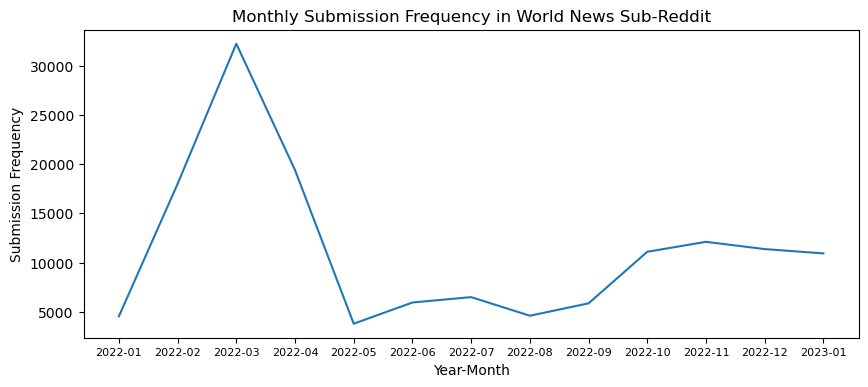

In [24]:
### Creating the visualization
plt.figure(figsize=(10,4))
plt.plot(df_date_viz['date_ym'], df_date_viz['count'])
plt.ylabel('Submission Frequency')
plt.xlabel('Year-Month')
plt.xticks(fontsize=8)
plt.title('Monthly Submission Frequency in World News Sub-Reddit')
plt.savefig("submissions-time-series.png")
plt.show()

From the above visualization, it can be interpreted that there was a large spike in the  number of submissions in March 2022. This can be attributed to the increased number of news articles on the advent of the Russia-Ukraine crisis. A smaller, but significant spike in October and November 2022 can be attributed to the conflict escalating to Phase-4, which marks massive strikes against Ukrainian infrastructure, Elon Musk buying Twitter, and the FIFA Football WorldCup 2022. 


In [25]:
### Viewing comment frequency over time 
#Grouping by number of comments
df_comments_group = df_date.groupby(['date_ym']).sum('num_comments')
#Sorting data by date
df_comments_group = df_comments_group.sort('date_ym')
#Converting to pandas for viz
df_comments_viz = df_comments_group.toPandas()
### Saving as csv 
df_comments_viz.to_csv("df_comments_viz.csv", index = False)

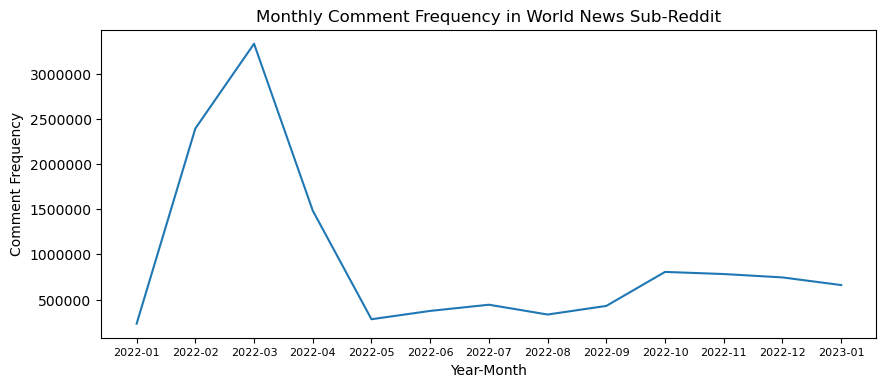

In [26]:
### Generating the visualization and saving as png 
plt.figure(figsize=(10,4))
plt.ticklabel_format(style='plain') 
plt.plot(df_comments_viz['date_ym'], df_comments_viz['sum(num_comments)'])
plt.ylabel('Comment Frequency')
plt.xlabel('Year-Month')
plt.xticks(fontsize=8)
plt.title('Monthly Comment Frequency in World News Sub-Reddit')
plt.savefig("comments-time-series.png")
plt.show()

In [27]:
#Grouping by date and NFSW boolean value
df_comments_over18 = df_date.groupby(['date_ym', 'over_18']).agg({'num_comments' : 'sum'})

#Sorting by date-time
df_comments_over18 = df_comments_over18.sort('date_ym')

### Splitting into two conditions
df_comments_over18_true = df_comments_over18.filter("over_18 == True")
df_comments_over18_false = df_comments_over18.filter("over_18 == False")

### Converting to Pandas 
df_comments_over18_true = df_comments_over18_true.toPandas()
df_comments_over18_false = df_comments_over18_false.toPandas()

### Saving to csv
df_comments_over18_true.to_csv("df_comments_over18_true.csv", index = False)
df_comments_over18_false.to_csv("df_comments_over18_false.csv", index = False)

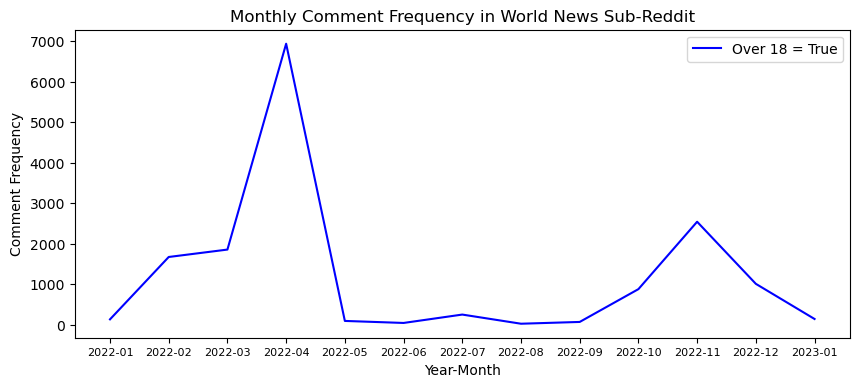

In [28]:
### Generating the visualizations and saving as png files  
plt.figure(figsize=(10,4)) 
plt.plot(df_comments_over18_true['date_ym'], df_comments_over18_true['sum(num_comments)'], label="Over 18 = True", color='blue')
plt.ylabel('Comment Frequency')
plt.xlabel('Year-Month')
plt.legend()
plt.xticks(fontsize=8)

plt.title('Monthly Comment Frequency in World News Sub-Reddit')
plt.savefig("comments-over18-true.png")
plt.show()

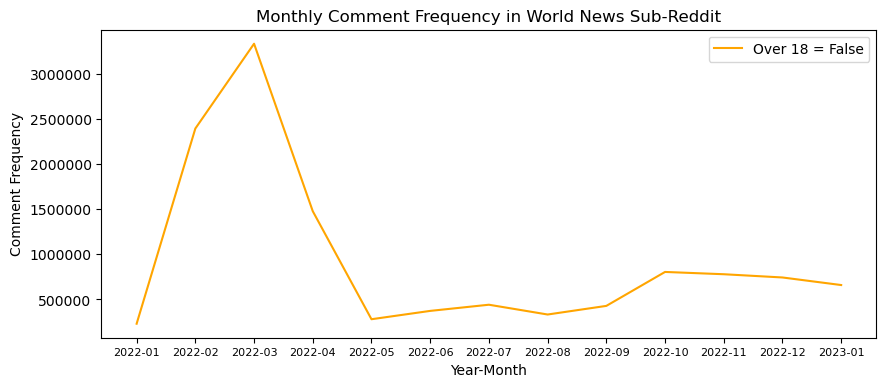

In [29]:
plt.figure(figsize=(10,4))
plt.ticklabel_format(style='plain') 
plt.plot(df_comments_over18_false['date_ym'], df_comments_over18_false['sum(num_comments)'], label="Over 18 = False", color='orange')
plt.ylabel('Comment Frequency')
plt.xlabel('Year-Month')
plt.legend()
plt.xticks(fontsize=8)
plt.title('Monthly Comment Frequency in World News Sub-Reddit')
plt.savefig("comments-over18-false.png")
plt.show()


The time-series analysis for the comment frequencies of the subreddit posts follow the same pattern as the submission frequency. However, it is interesting to note that, albeit lesser in number to total comments, the count of NSFW comments is always higher a month after spikes in submission frequencies. This suggests that when there are more NSFW comments, after the subreddit has higher activity and engagement. 


#### Inter-Quartiles of Scores in Submissions over time. 

In [30]:
df_score_grouped = df_date.groupby('date_ym').agg(f.expr('percentile(score, array(0.25))')[0].alias('Q25'), \
                                                  f.expr('percentile(score, array(0.5))')[0].alias('median'), \
                                                  f.expr('percentile(score, array(0.75))')[0].alias('Q75'))

df_score_grouped = df_score_grouped.sort('date_ym')
df_score_grouped = df_score_grouped.toPandas()
df_score_grouped.to_csv("df_score_grouped.csv")

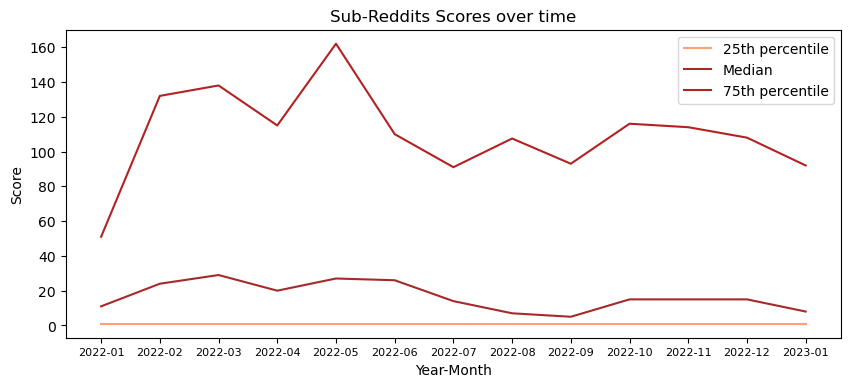

In [31]:
### Generating the visualization and saving as png
plt.figure(figsize=(10,4))
plt.ticklabel_format(style='plain') 
plt.plot(df_score_grouped['date_ym'], df_score_grouped['Q25'], label="25th percentile", color='lightsalmon')
plt.plot(df_score_grouped['date_ym'], df_score_grouped['median'], label="Median", color='brown')
plt.plot(df_score_grouped['date_ym'], df_score_grouped['Q75'], label="75th percentile", color='firebrick')

plt.ylabel('Score')
plt.xlabel('Year-Month')
plt.legend()
plt.xticks(fontsize=8)
plt.title('Sub-Reddits Scores over time')
plt.savefig("score-distribution-over-time.png")
plt.show()


The above time series analysis revealed that median and 25th percentile scores don’t vary much over time. However, the 75th percentile (posts with higher upvotes) varies more over time. These spikes are not consistent with the submission and comment frequency spikes. 


#### Submission Frequency of Top 2 Authors

In [33]:
### Getting the top two authors 
df_sub.filter(col("author") != "[deleted]").groupby("author").count().alias('count').orderBy(col("count").desc()).show(2, truncate = False)


+-------------+-----+
|author       |count|
+-------------+-----+
|DoremusJessup|1650 |
|Saltedline   |964  |
+-------------+-----+
only showing top 2 rows



In [34]:
### Considering the submission frequency of the top two authors
df_author = df_date.filter((df_date.author=='DoremusJessup') | (df_date.author=='Saltedline'))
df_author_grouped = df_author.groupby(['date_ym', 'author']).count()
df_author_grouped = df_author_grouped.sort('date_ym')
### Creating datasets for each author 
df_author_dj = df_author_grouped.filter(df_author_grouped.author == "DoremusJessup")
df_author_sl = df_author_grouped.filter(df_author_grouped.author == "Saltedline")
### Sorting 
df_author_dj = df_author_dj.sort('date_ym')
df_author_sl = df_author_sl.sort('date_ym')

df_author_dj = df_author_dj.toPandas()
df_author_sl = df_author_sl.toPandas()

df_author_dj.to_csv("df_author_dj.csv", index = False)
df_author_sl.to_csv("df_author_sl.csv", index = False)

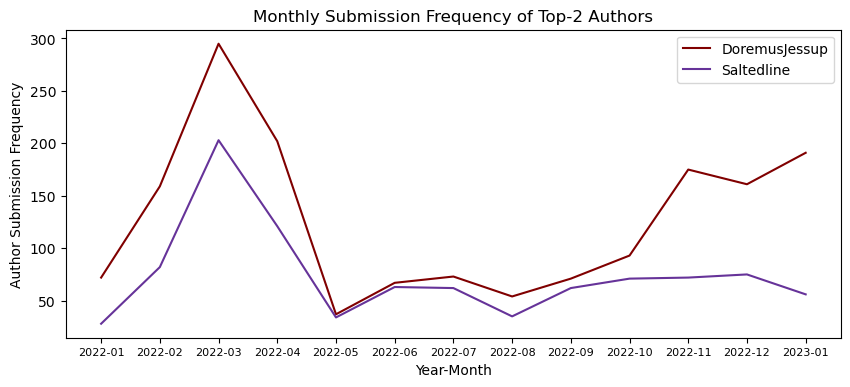

In [35]:
### Generating the visualization and saving to png 
plt.figure(figsize=(10,4))
plt.plot(df_author_dj['date_ym'], df_author_dj['count'], label="DoremusJessup", color='maroon')
plt.plot(df_author_sl['date_ym'], df_author_sl['count'], label="Saltedline", color='rebeccapurple')
plt.ylabel('Author Submission Frequency')
plt.xlabel('Year-Month')
plt.legend()
plt.xticks(fontsize=8)

plt.title('Monthly Submission Frequency of Top-2 Authors')
plt.savefig("top2-authors.png")
plt.show()

Finally, the submission frequency of the top two authors, Doremusjessup and Saltedline,  were visualized. This time series analysis is similar to the overall submission and comment frequency over time for this subreddit. However, Doresmusjessup contributed more submissions in the second half of the year. This indicates that certain authors may have had increased activities over certain time-periods, and requires further exploration. 


### Most Popular News 

In the submissions and comments frequency graph above, a sharp peak was observed which could be associated to the ongoing war in Ukraine. The following analysis looks at the most highly scored news stories, the news sites that occur most in the submissions dataset, the presence of a live thread and how it compares with usual submissions

In [36]:
### Top news stories 
df_sub.orderBy(col("score").desc()).select("title", "score", "id", "domain").show(10) 

### Creating dummy column for posts in the top 100 
top_100 = df_sub.orderBy(col("score").desc()).select("id").take(100)
top_100_id = [row.id for row in top_100] ### Converting to usable list format 
df_sub = df_sub.withColumn("Top_100", \
                           when(col("id").isin(top_100_id), lit(1)) \
                           .otherwise(lit(0)))
df_sub.printSchema()

+--------------------+------+------+-----------------+
|               title| score|    id|           domain|
+--------------------+------+------+-----------------+
|Vladimir Putin's ...|199019|t3pgaz|     newsweek.com|
|Queen Elizabeth I...|188321|x96k3v|        bbc.co.uk|
|Rejecting US evac...|171178|t1o8wq|timesofisrael.com|
|Anonymous leaks d...|165018|t1f287|    cybernews.com|
|Kyiv: full consen...|151977|t20u4i|       uawire.org|
|Ukraine President...|150991|t67pbu|       nypost.com|
|Macron wins Frenc...|139536|ub0f7j|       lemonde.fr|
|A massive leak fr...|137897|sx5xuf|  theguardian.com|
|Greenland permane...|133802|rwpqjk|optimistdaily.com|
|Anti-war protests...|132442|t0fhd3|      theweek.com|
+--------------------+------+------+-----------------+
only showing top 10 rows

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguishe

In [37]:
### Most shared news sites 
most_posted_news =  df_sub.filter(col("domain") != "") \
                    .groupby("domain") \
                    .agg(f.count("domain").alias("No of Posts"), \
                         f.round(f.avg("score"), 2).alias("Average Score"), \
                         f.sum("num_comments").alias("Total Comments"), \
                         f.sum("Top_100").alias("No. of Posts in Top 100")) \
                    .withColumnRenamed("domain", "News Site") \
                    .orderBy(col("No of Posts").desc()).limit(20).toPandas()
most_posted_news

,News Site,No of Posts,Average Score,Total Comments,No. of Posts in Top 100
0,reuters.com,10408,1016.02,950262,2
1,theguardian.com,5302,799.05,369019,3
2,bbc.com,3723,406.55,150287,0
3,youtube.com,3270,0.99,1395,0
4,youtu.be,3155,0.99,1478,0
5,apnews.com,2781,829.10,193889,2
6,aljazeera.com,2124,413.45,93387,0
7,businessinsider.com,2100,3835.48,561072,12
8,cnn.com,1931,833.87,157210,3
9,pravda.com.ua,1701,2859.35,317535,7


In [38]:
most_posted_news.to_csv("most_posted_news.csv", index = False) ### Saving to csv  

As can be seen above, the most popular news sites on the subreddit over the past year is generally from western countries. This might affect the type of articles and news being spread in this particular subreddit. 

We now evaluate for the presence of live threads and the type of news they share. 

In [93]:
### Creating a dummy column to catch Live threads 
print(df_sub.filter(col("title").startswith("/r/WorldNews Live Thread:")).count())
### Are all live threads about Russia? 
print(df_sub.filter(col("title").startswith("/r/WorldNews Live Thread: Russian Invasion of Ukraine Day")).count())
### Creating dummy variable which will be useful in topic modeling 
df_sub = df_sub.withColumn("Live_Thread", col("title").startswith("/r/WorldNews Live Thread:"))
df_sub.printSchema()

355
355
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- id: string (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)
 |-- Live_Thread: boolean (nullable = true)



Since all the live threads are about Russia's war on Ukraine, we now have an opportunity to evaluate the comments of the live thread against regular submissions dealing with the war.  

In [40]:
### To extract comments for a particular submission, we need to ensure that the ids are in similar form 
### Harmonizing link_id and id columns 
### Getting the length of id columns 
df_sub.withColumn("length_id", f.length("id")).select("length_id").groupby("length_id").count().show()

### Getting the length of link_id columns 
df_com.withColumn("length_id", f.length("link_id")).select("length_id").groupby("length_id").count().show()

### Looking at the link_id with length 8 
df_com.withColumn("length_id", f.length("link_id")).select("length_id", "link_id").filter("length_id == 8").show()

### Looking at number of rows with prefixes 
print(df_com.filter(col("link_id").rlike("^\w+_")).select("link_id").count())

### Creating new column with prefix 
df_com = df_com.withColumn("submission_id", f.regexp_replace("link_id", "^\w+_", ""))

df_com.printSchema()

+---------+------+
|length_id| count|
+---------+------+
|        6|135331|
|        7| 10996|
+---------+------+



+---------+--------+
|length_id|   count|
+---------+--------+
|        8|       2|
|        9|15529135|
|       10|  642458|
+---------+--------+

+---------+--------+
|length_id| link_id|
+---------+--------+
|        8|t3_fr7hk|
|        8|t3_9q9ul|
+---------+--------+



16171595
root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: double (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- body_length: integer (nullable = true)
 |-- created_date: string (nullable = true)
 |-- date_clean: date (nullable = true)
 |-- submission_id: string (nullable = true)



In [41]:
### Getting the live thread comments 
live_thread = df_sub.filter("Live_Thread == true").select("id").collect()
live_thread_ids = top_100_id = [row.id for row in live_thread] 

live_thread_comment = df_com.filter(col("submission_id").isin(live_thread_ids))

### Creating a dummy to catch Russia-Ukraine war based news 
df_sub = df_sub.withColumn("War_Dummy", col("title").rlike("Russia|Russian|Ukraine|Ukranian|Putin|Zelensky|(?i)War"))
russia_without_thread_ids = df_sub.filter("War_Dummy == true").filter("Live_Thread == false").select("id").collect()
russia_without_thread_ids = [row.id for row in russia_without_thread_ids]

russia_without_thread_comment = df_com.filter(col("submission_id").isin(russia_without_thread_ids))

In [42]:
live_thread_pd = live_thread_comment.agg(f.countDistinct("submission_id").alias("Total Posts"), \
                                         f.count("id").alias("Total Comments"), \
                                         f.round(f.sum(when(col("controversiality") > 0, col("controversiality")))/f.count("id")*100, 2).alias("Controversial Comments"), \
                                         f.round(f.count(when(col("gilded") > 0, col("id")))/f.count("id")*100, 2).alias("Gilded Comments"), \
                                         f.round(f.count(when(~col("distinguished").isNull(), col("id")))/f.count("id")*100, 2).alias("Distinguished comments")).toPandas()

russia_pd = russia_without_thread_comment.agg(f.countDistinct("submission_id").alias("Total Posts"), \
                                              f.count("id").alias("Total Comments"), \
                                              f.round(f.sum(when(col("controversiality") > 0, col("controversiality")))/f.count("id")*100, 2).alias("Controversial Comments"), \
                                              f.round(f.count(when(col("gilded") > 0, col("id")))/f.count("id")*100, 2).alias("Gilded Comments"), \
                                              f.round(f.count(when(~col("distinguished").isNull(), col("id")))/f.count("id")*100, 2).alias("Distinguished comments")).toPandas()

23/03/25 01:24:31 WARN DAGScheduler: Broadcasting large task binary with size 1520.6 KiB
23/03/25 01:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1225.3 KiB


In [43]:
threads = [live_thread_pd, russia_pd]
comment_comparison = pd.concat(threads)
comment_comparison.index = ["Live Thread", "Russia"] ### Setting Index 
comment_comparison

,Total Posts,Total Comments,Controversial Comments,Gilded Comments,Distinguished comments
Live Thread,353,1824577,2.84,0.03,0.05
Russia,45863,6347014,4.48,0.05,0.10


In [44]:
### Saving the table 
comment_comparison.to_csv("comment_comparison.csv", index = False)

The table above captures the percentage of comments that were controversial, gilded and distinguished for the live thread and for normal submissions dealing with the war. More controversiality is present in regular submissions as compared to live thread, possible due to larger number of normal posts. 

### Potential topics in comments 

Before we get in full-fledged NLP analysis, we wanted to observe if we could capture topics in comments under posts on war using Word Cloud visualizations. 

In [45]:
### Getting the comments of the top 5 news stories id  
top_5 = df_sub.orderBy(col("score").desc()).select("id").take(5)
top_5_id = [row.id for row in top_5] ### Converting to usable list format 

### Using the previously created submission_id we can directly compare ids from submissions and comments tables 
df_com_sel_0 = df_com.filter(col("submission_id") == top_5_id[0])
print(df_com_sel_0.count())

df_com_sel_1 = df_com.filter(col("submission_id") == top_5_id[1])
print(df_com_sel_1.count())

df_com_sel_2 = df_com.filter(col("submission_id") == top_5_id[2])
print(df_com_sel_2.count())

df_com_sel_3 = df_com.filter(col("submission_id") == top_5_id[3])
print(df_com_sel_3.count())

df_com_sel_4 = df_com.filter(col("submission_id") == top_5_id[4])
print(df_com_sel_4.count())

6633


12656


7863


6102


6669


In [46]:
### For setting the word cloud we need to clean the text 
# Clean text
df_clean = df_com_sel_0.select('link_id', (lower(regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
# Tokenize text
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('link_id', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('link_id', 'words_clean')


# Clean text
df_clean1 = df_com_sel_1.select('link_id', (lower(regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
# Tokenize text
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
df_words_token1 = tokenizer.transform(df_clean1).select('link_id', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw1 = remover.transform(df_words_token1).select('link_id', 'words_clean')



# Clean text
df_clean2 = df_com_sel_2.select('link_id', (lower(regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
# Tokenize text
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
df_words_token2 = tokenizer.transform(df_clean2).select('link_id', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw2 = remover.transform(df_words_token2).select('link_id', 'words_clean')



# Clean text
df_clean3 = df_com_sel_3.select('link_id', (lower(regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
# Tokenize text
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
df_words_token3 = tokenizer.transform(df_clean3).select('link_id', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw3 = remover.transform(df_words_token3).select('link_id', 'words_clean')


# Clean text
df_clean4 = df_com_sel_4.select('link_id', (lower(regexp_replace('body', "[^a-zA-Z\\s]", "")).alias('body')))
# Tokenize text
tokenizer = Tokenizer(inputCol='body', outputCol='words_token')
df_words_token4 = tokenizer.transform(df_clean4).select('link_id', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw4 = remover.transform(df_words_token4).select('link_id', 'words_clean')

In [48]:
words_0 = df_words_no_stopw.withColumn("words_clean", f.concat_ws(", ",col("words_clean")))
words_1 = df_words_no_stopw1.withColumn("words_clean", f.concat_ws(", ",col("words_clean")))
words_2 = df_words_no_stopw2.withColumn("words_clean", f.concat_ws(", ",col("words_clean")))
words_3 = df_words_no_stopw3.withColumn("words_clean", f.concat_ws(", ",col("words_clean")))
words_4 = df_words_no_stopw4.withColumn("words_clean", f.concat_ws(", ",col("words_clean")))

In [49]:
word_count_0 = words_0.groupBy("link_id").agg( *[f.array_join(f.collect_list(column), "").alias(column) for column in words_0.columns if column =='words_clean' ])
word_count_1 = words_1.groupBy("link_id").agg( *[f.array_join(f.collect_list(column), "").alias(column) for column in words_0.columns if column =='words_clean' ])
word_count_2 = words_2.groupBy("link_id").agg( *[f.array_join(f.collect_list(column), "").alias(column) for column in words_0.columns if column =='words_clean' ])
word_count_3 = words_3.groupBy("link_id").agg( *[f.array_join(f.collect_list(column), "").alias(column) for column in words_0.columns if column =='words_clean' ])
word_count_4 = words_4.groupBy("link_id").agg( *[f.array_join(f.collect_list(column), "").alias(column) for column in words_0.columns if column =='words_clean' ])

In [50]:
first_element_0 = word_count_0.select(f.first('words_clean')).collect()[0][0]
first_element_1 = word_count_1.select(f.first('words_clean')).collect()[0][0]
first_element_2 = word_count_2.select(f.first('words_clean')).collect()[0][0]
first_element_3 = word_count_3.select(f.first('words_clean')).collect()[0][0]
first_element_4 = word_count_4.select(f.first('words_clean')).collect()[0][0]

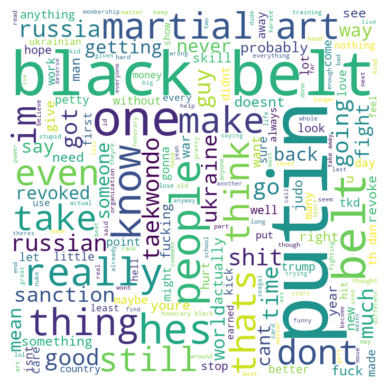

In [51]:
### Generating the WordCloud for first most popular submission
# Create and Generate a Word Cloud Image
wordcloud = WordCloud(width=700, 
                      height=700,
                      prefer_horizontal=0.5,
                      background_color="white", 
                      mode="RGBA")
wordcloud_text = wordcloud.generate(first_element_0)

#Display the generated image
plt.imshow(wordcloud_text, interpolation="bilinear")
plt.axis('off')
plt.show()
# Save it as png 
wordcloud_text.to_file("text_0.png")


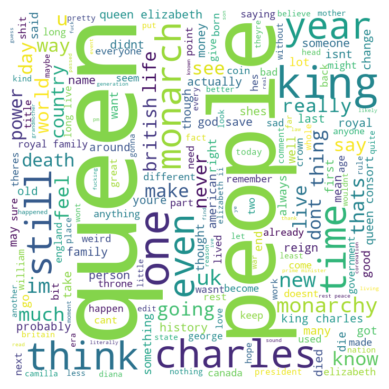

In [52]:
wordcloud_text1 = wordcloud.generate(first_element_1)

#Display the generated image
plt.imshow(wordcloud_text1, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
wordcloud_text1.to_file("text_1.png")

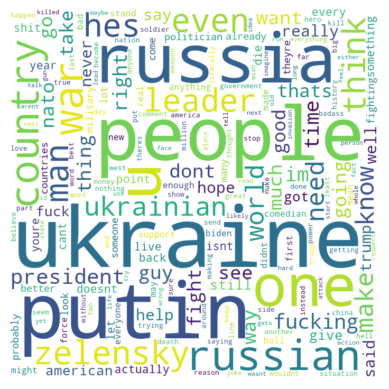

In [53]:
wordcloud_text2 = wordcloud.generate(first_element_2)

#Display the generated image
plt.imshow(wordcloud_text2, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
wordcloud_text2.to_file("text_2.png")

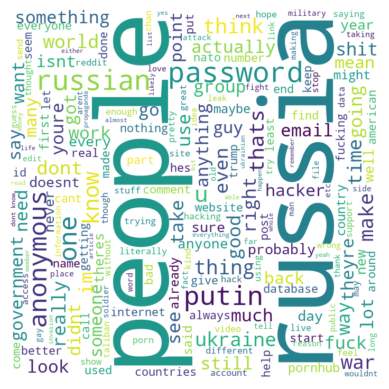

In [54]:
wordcloud_text3 = wordcloud.generate(first_element_3)

#Display the generated image
plt.imshow(wordcloud_text3, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
wordcloud_text3.to_file("text_3.png")

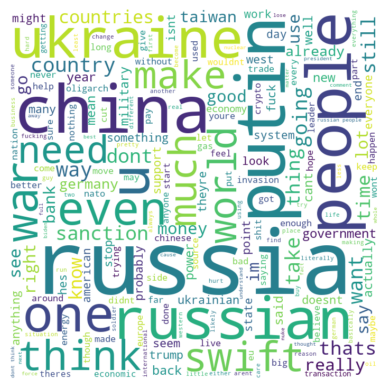

In [55]:
wordcloud_text4 = wordcloud.generate(first_element_4)

#Display the generated image
plt.imshow(wordcloud_text4, interpolation="bilinear")
plt.axis('off')
plt.show()
# save
wordcloud_text2.to_file("text_4.png")

These word clouds reveal that the <b> Russia-Ukraine conflict </b>, and political leaders of these countries were the most repeated words. We also find words related to Queen Elizabeth II’s death and the British royal family to be quite repetitive as well. Other frequent words were related to governments in general, countries (particularly China and Taiwan), money and transactions, and pop-culture in music (Taylor swift). 

### Comparing with another data source

In [65]:
#Subsetting to posts related to Russia-Ukraine War
df_sub_war = df_sub.filter(col("War_dummy")== True)

#Creating dummies for each sub_event_type chosen from ACLED Data
df_sub_war = df_sub_war.withColumn("armed_clash_dummy", (col("title").rlike("(?i)armed clash|(?i)arms|(?i)organized group|(?i)armed conflict")).cast(IntegerType()))

df_sub_war = df_sub_war.withColumn("shelling_artillery_missile_dummy", (col("title").rlike("(?i)shelling|(?i)artillery|(?i)missile|(?i)rocket propelled grenades")).cast(IntegerType()))

df_sub_war = df_sub_war.withColumn("re_landmines_ied_dummy", (col("title").rlike("(?i)remote explosives|(?i)landmines|(?i)IED|(?i)improvised explosive device|(?i)detonate|(?i)unexploded ordinances|(?i)UXO|(?i) explosive")).cast(IntegerType()))

df_sub_war = df_sub_war.withColumn("air_drone_strike_dummy", (col("title").rlike("(?i)airstrike|(?i)drone strike|(?i)aerial vehicles|(?i)aerial systems|(?i)drone attack|(?i)air base")).cast(IntegerType()))

df_sub_war = df_sub_war.withColumn("disrupted_weapons_dummy", (col("title").rlike("(?i)weapons|(?i)explosives|(?i)hypersonic weapons|(?i)hypersonic missiles|(?i)disrupted weapons|(?i)disrupted technology")).cast(IntegerType()))


In [66]:
#Changing date-time from unix timestamp
df_sub_war = df_sub_war.withColumn("changed_utc",  f.from_unixtime(col("created_utc"),"MM-dd-yyyy"))

df_sub_war = df_sub_war.select(col('changed_utc'), col('armed_clash_dummy'), col('shelling_artillery_missile_dummy'), \
                               col('re_landmines_ied_dummy'), col('air_drone_strike_dummy'), col('disrupted_weapons_dummy'))

df_sub_war.show(10)

+-----------+-----------------+--------------------------------+----------------------+----------------------+-----------------------+
|changed_utc|armed_clash_dummy|shelling_artillery_missile_dummy|re_landmines_ied_dummy|air_drone_strike_dummy|disrupted_weapons_dummy|
+-----------+-----------------+--------------------------------+----------------------+----------------------+-----------------------+
| 04-06-2022|                0|                               0|                     0|                     0|                      0|
| 10-01-2022|                0|                               0|                     0|                     0|                      0|
| 11-14-2022|                0|                               0|                     0|                     0|                      0|
| 09-05-2022|                0|                               0|                     0|                     0|                      0|
| 11-26-2022|                0|                        

In [67]:
df_sub_war_grouped = df_sub_war.groupby('changed_utc').sum()
df_sub_war_grouped.show()

+-----------+----------------------+-------------------------------------+---------------------------+---------------------------+----------------------------+
|changed_utc|sum(armed_clash_dummy)|sum(shelling_artillery_missile_dummy)|sum(re_landmines_ied_dummy)|sum(air_drone_strike_dummy)|sum(disrupted_weapons_dummy)|
+-----------+----------------------+-------------------------------------+---------------------------+---------------------------+----------------------------+
| 10-17-2022|                     1|                                    6|                          3|                          7|                           8|
| 12-09-2022|                     5|                                    9|                          5|                          0|                           1|
| 10-05-2022|                     1|                                    6|                          5|                          2|                           7|
| 06-05-2022|                     3|    

In [69]:
#Reading in the ACLED data
df_acled = pd.read_csv('../data/csv/ACLED_aggregated.csv')
df_acled

,event_date,Armed clash,Shelling/artillery/missile attack,Remote explosive/landmine/IED,Air/drone strike,Disrupted weapons use
0,1/1/2022,5,8,0,0,0
1,1/2/2022,3,0,0,0,0
2,1/3/2022,1,4,0,0,0
3,1/4/2022,6,7,0,0,1
4,1/5/2022,2,3,0,0,0
...,...,...,...,...,...,...
391,1/27/2023,15,92,0,0,0
392,1/28/2023,16,99,1,2,0
393,1/29/2023,12,76,0,4,1
394,1/30/2023,13,109,1,1,2


In [71]:
#Convert the event date column to date-type
df_acled['event_date'] =  pd.to_datetime(df_acled['event_date'], format='%m/%d/%Y')

#Converting back to string type to be able to merge properly
df_acled['changed_utc']=df_acled['event_date'].astype(str)

### In order to combine the two datasets using dates we have to harmonize the date format 
df_acled['changed_utc'] = df_acled['changed_utc'].str.replace('/','-')

In [72]:
#Reading the ACLED Data as pyspark dataframe - then only can they be merged
df_acled_spark = spark.createDataFrame(df_acled)

#Changing date format 
df_acled_spark = df_acled_spark. \
    withColumn("changed_utc", date_format("event_date", "MM-dd-yyyy"))

#Drop event_date column 
df_acled_spark = df_acled_spark.drop('event_date')

#Changing long to int datatypes so that they can be merged
df_acled_spark2 = df_acled_spark.select(col('changed_utc'), col('Armed clash').cast('int'),col('Shelling/artillery/missile attack').cast('int'), col('Remote explosive/landmine/IED').cast('int'),
                                        col('Air/drone strike').cast('int'),  col('Disrupted weapons use').cast('int'))

df_acled_spark2.show(3)

+-----------+-----------+---------------------------------+-----------------------------+----------------+---------------------+
|changed_utc|Armed clash|Shelling/artillery/missile attack|Remote explosive/landmine/IED|Air/drone strike|Disrupted weapons use|
+-----------+-----------+---------------------------------+-----------------------------+----------------+---------------------+
| 01-01-2022|          5|                                8|                            0|               0|                    0|
| 01-02-2022|          3|                                0|                            0|               0|                    0|
| 01-03-2022|          1|                                4|                            0|               0|                    0|
+-----------+-----------+---------------------------------+-----------------------------+----------------+---------------------+
only showing top 3 rows



In [73]:
df_acled_spark2.printSchema()
df_sub_war.printSchema()

#Both the datasets have date column in yyyy-mm-dd format
#Performing a left join to ensure all the rows of sub-reddit dataframe are available

reddit_acled = df_sub_war.join(df_acled_spark2, 'changed_utc', 'left')

root
 |-- changed_utc: string (nullable = true)
 |-- Armed clash: integer (nullable = true)
 |-- Shelling/artillery/missile attack: integer (nullable = true)
 |-- Remote explosive/landmine/IED: integer (nullable = true)
 |-- Air/drone strike: integer (nullable = true)
 |-- Disrupted weapons use: integer (nullable = true)

root
 |-- changed_utc: string (nullable = true)
 |-- armed_clash_dummy: integer (nullable = true)
 |-- shelling_artillery_missile_dummy: integer (nullable = true)
 |-- re_landmines_ied_dummy: integer (nullable = true)
 |-- air_drone_strike_dummy: integer (nullable = true)
 |-- disrupted_weapons_dummy: integer (nullable = true)



In [74]:
reddit_acled.show()

+-----------+-----------------+--------------------------------+----------------------+----------------------+-----------------------+-----------+---------------------------------+-----------------------------+----------------+---------------------+
|changed_utc|armed_clash_dummy|shelling_artillery_missile_dummy|re_landmines_ied_dummy|air_drone_strike_dummy|disrupted_weapons_dummy|Armed clash|Shelling/artillery/missile attack|Remote explosive/landmine/IED|Air/drone strike|Disrupted weapons use|
+-----------+-----------------+--------------------------------+----------------------+----------------------+-----------------------+-----------+---------------------------------+-----------------------------+----------------+---------------------+
| 02-16-2022|                0|                               0|                     0|                     0|                      0|          5|                               21|                            0|               2|                    0|


In [79]:
#Changing data to Pandas for visualization
reddit_acled = reddit_acled.toPandas()
reddit_acled.to_csv("reddit_acled_merge.csv", index = False)



/mnt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


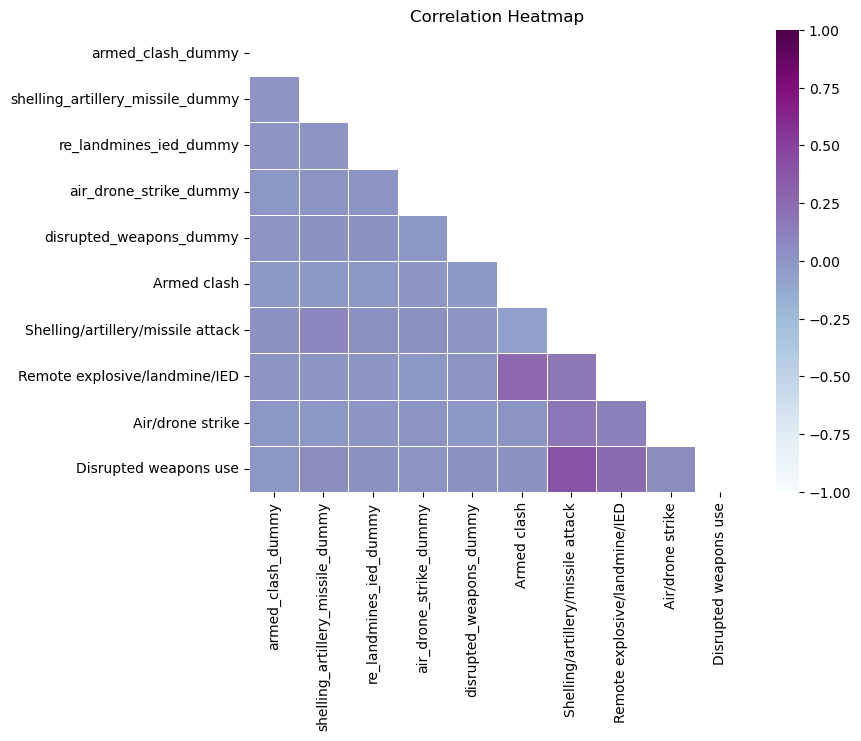

In [80]:
#Heatmap to visualize potential multicollinearity
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(reddit_acled.corr(), dtype=np.bool))
heatmap = sns.heatmap(reddit_acled.corr(),vmin=-1, vmax=1, linewidths=.5, cmap="BuPu", mask = mask)
heatmap.set_title('Correlation Heatmap');
plt.savefig('heatmap.png', bbox_inches="tight")

By analyzing the correlations between the events counts from the world-news subreddit and ACLED, it can be concluded that they are not quite similar. It suggests that the world news subreddit may not account for all the regional-level news events that ACLED captures, thereby having lower counts for the same sub-event types. 


In [94]:
spark.stop()